In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

from pathlib import Path
from matLoader import loadMat
from imageComp import weighted_average_images, npImage

In [2]:
f = r"C:\Users\augus\NIN_Stuff\data\koenData\Koen_to_Augustijn\Ajax_20241012_001_normcorr_SPSIG_Res.mat"
fdata = loadMat(f)
f2 = r"C:\Users\augus\NIN_Stuff\data\koenData\Koen_to_Augustijn\RFByMiceData.mat"
SNRdata = loadMat(f2)

Using custom loadMat to load matlab file into a dictionary object

In [4]:
def plotAvgSig(data, idx:int=0, imageFolder:str=r"C:\Users\augus\NIN_Stuff\data\koenData\Koen_to_Augustijn\ajaxNeuronAvg"):
    def plotForOne(signal, name, filepath):
        mean = np.mean(signal, axis=1)
        std = np.std(signal, axis=1)

        x = np.arange(24)

        plt.errorbar(x, mean, yerr=std, fmt='-o', capsize=5)
        #plt.xlabel('Time point')
        #plt.ylabel('Average value')
        plt.title(name)
        plt.savefig(filepath)
        plt.close()

    curDir = Path(os.path.join(imageFolder,str(idx)))
    curDir.mkdir(exist_ok=True)

    signals = ["CaSig", "CaSigRaw", "CaSigCorrected", "CaDen", "CaDenCorrected", "CaDec", "CaDeconCorrected","CaSpike_prob"]
    for signal in signals:
        filepath = os.path.join(curDir, signal)
        curSig = data.Res[signal][:,:,idx]
        plotForOne(curSig, signal, filepath)

    return

curDir = Path(r"C:\Users\augus\NIN_Stuff\data\koenData\Koen_to_Augustijn\ajaxNeuronAvg")
curDir.mkdir(exist_ok=True)
for i in range(0,10):
    plotAvgSig(fdata, i)


plotting average traces with errors bars. Initially seen that CaDec and CaDeconCorrected seem to have the clearest trace. This could be full of errors and a much more thorough check should be run in order to ensure there is no loss in information/data etc... 

Need to get the full non trial locked data for a more thorough analysis

In [4]:
def normaliseNeuron(arr:np.ndarray, idx:int):
    #assume format is #trials , neurons

    curArr = arr[:, idx]

    min_val = np.min(curArr)
    max_val = np.max(curArr)

    normalized_array = (curArr - min_val) / (max_val - min_val)
    return normalized_array

def getPaths(basePath:str, log:np.ndarray, extension:str=".npy"):
    if log.ndim != 1:
        raise ValueError("expect one dimensional path")
    length = log.shape[0]

    paths = [0]*length
    for i in range(length):
        end = f"{int(log[i]):04d}{extension}"
        origPath = os.path.join(basePath, end)
        corPath = npImage._checkPath(origPath, extension)
        paths[i] = corPath
    return paths

In [5]:
print([key for key in SNRdata.Ajax.info.keys()])
print(SNRdata.Ajax.info.resMat.shape)

['msdelay', 'x', 'y', 'px', 'py', 'Area', 'azi', 'ele', 'onFWHM', 'offFWHM', 'rfsz', 'RSQ', 'SNR', 'resMat', 'resMatGauss']
(403, 12, 16, 2)


In [25]:
def saveResMatImg(arr:np.ndarray, savePath:str, bufferColour:str="black"):
    imgShape = arr.shape
    assert len(imgShape) == 3
    assert imgShape[2] == 2
    #3 dims, 12, 16, 2
    #virtually stack them into 25*16 img and then save that img


    cleanArr = npImage._normalise(arr, 255).astype(np.uint8)

    if bufferColour.lower().strip() == "black":
        bufferInt = 0
    elif bufferColour.lower().strip() == "white":
        bufferInt = 255
    else:
        raise ValueError("Unknown buffer colour, accepted are: 'black', 'white'")

    buffer = np.full((2, imgShape[1]), bufferInt)
    mergedImg = np.vstack([cleanArr[:, :, 0], buffer, cleanArr[:, :, 1]])
    mergedImg = npImage(mergedImg)
    mergedImg.resize(15, resample=Image.NEAREST)
    mergedImg.save(savePath)
    return

testPath = r"C:\Users\augus\NIN_Stuff\NIN personal projects\bias_results\tester.png"
testArr = SNRdata.Ajax.info.resMat[151,:,:,:]
saveResMatImg(testArr, testPath, "white")

In [23]:

def getGoodNeurons(info:dict, enforce = True, SNRthreshold:float=4, RSQthreshold:float=0.33):
    nNeurons = info.SNR.shape[0]
    snr = info.SNR
    rsq = info.RSQ
    score = []
    goodNeurons = []
    for i in range(nNeurons):

        light = False
        if snr[i, 0] > SNRthreshold and rsq[i, 0] > RSQthreshold:
            light = True

        dark = False
        if snr[i, 1] > SNRthreshold and rsq[i, 1] > RSQthreshold:
            dark = True

        if enforce:
            if not (light and dark):
                continue
        else:
            if not (light or dark):
                continue

        goodNeurons.append(i)
        if light:
            if dark:
                tscore = 2
            else:
                tscore = 1
        else:
            tscore = 0
        score.append(tscore)

    return goodNeurons, score

good, score = getGoodNeurons(SNRdata.Ajax.info)
print(good)
print(score)
print(len(good))

[3, 4, 17, 19, 22, 23, 25, 27, 31, 32, 35, 36, 37, 42, 47, 53, 59, 60, 61, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 84, 86, 88, 94, 95, 98, 99, 100, 102, 103, 104, 105, 113, 116, 117, 119, 120, 125, 126, 129, 134, 140, 152, 153, 154, 155, 156, 159, 162, 163, 164, 166, 167, 168, 169, 170, 172, 173, 177, 179, 180, 181, 183, 184, 185, 198, 207, 222, 232, 238, 246, 249, 273, 276, 277, 289, 304, 305, 306, 311, 314, 315, 316, 320, 326, 335, 336, 338, 347, 356, 357, 359, 364, 365, 370, 381, 382, 384, 391, 398]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
115


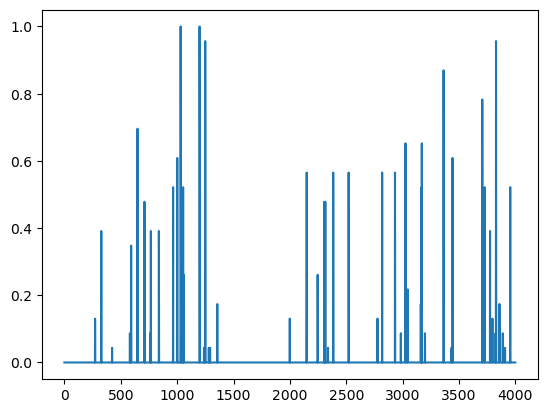

In [ ]:
neuronID = 2

Sig = fdata.Res.CaDec
SigCor = fdata.Res.CaDeconCorrected
imgID = fdata.info.Stim.Log
baseIMGPath = Path(r"C:\Users\augus\NIN_Stuff\data\koenData\Koen_to_Augustijn\4000imgNPY")
x = np.arange(4000)


imgIDPaths = getPaths(baseIMGPath, imgID)
for path in imgIDPaths:
    assert os.path.isfile(path)

AvgSig = Sig.sum(axis=0)
AvgSigCor = SigCor.sum(axis=0)
normalised = normaliseNeuron(AvgSig, neuronID)


show = True
if show:
    plt.plot(x, normalised)
    plt.show()

CHOOSE ABOVE KEY VARS

In [24]:
def test_blur(paths: list[str]) -> np.ndarray:
    """
    Loads image matrices from .npy files, applies weights, sums them,
    and normalizes by the number of images.
    """
    imageFolder=r"C:\Users\augus\NIN_Stuff\data\koenData\Koen_to_Augustijn\ajaxNeuronAvg"
    folderName = "test_blur"

    curDir = Path(os.path.join(imageFolder,folderName))
    curDir.mkdir(exist_ok=True)

    if len(paths) <= 0:
        return None

    for i in range(1, len(paths)):
        print(f"iteration: {i}")
        matrix = npImage(paths[i])
        matrix.blur(6)
        finalMatrix = matrix.gamma_correction(1.2)
        toSave = npImage(finalMatrix)

        filepath = os.path.join(curDir, str(i))
        toSave.save(filepath, ".png")
    # Normalize by number of images
    return
"""
test_blur(imgIDPaths[:50])
"""

'\ntest_blur(imgIDPaths[:50])\n'

In [ ]:
from imageComp import weighted_average_images

In [42]:
def randomizer_weighted_average(images:list, nWeights:list, base_path:str, nPerms:int = 1, **kwargs):

    def runSelf(n_ones:int, savePath:str, **kwargs):
        post_blur = kwargs.pop("post_blur", False)

        mask = np.zeros(len(images), dtype=bool)
        mask[np.random.choice(len(images), size = n_ones, replace=False)] = True
        selectedImages = images[mask]
        weights = np.ones(n_ones)
        finalImg = npImage(weighted_average_images(selectedImages, weights, **kwargs))
        finalImg.gamma_correction(5, save=True)
        finalImg.save(savePath, [".npy",".png"])

        if post_blur:
            finalImg.blur(5, save=True)
            nPath = Path(savePath)
            nSavePath = nPath.with_name(nPath.stem + "_post_blur" + nPath.suffix)
            finalImg.save(nSavePath, [".npy",".png"])
        return

    if nPerm < 1 or not type(int):
        raise ValueError("number of permutations must be a number greater than 0")

    if max(nWeights) > len(images):
        raise ValueError("maximum weight number is more than the number of images")
    
    condition = kwargs.pop("condition", "")
    if not isinstance(condition, str):
        raise ValueError("condition must be a string")

    images = np.array(images)

    for weight in nWeights:
        for iter in range(nPerms):
            if condition:
                iter_name = f"{str(condition)}_{str(weight)}_{str(iter)}"
            else:    
                iter_name = f"{str(weight)}_{str(iter)}"

            savePath = os.path.join(base_path, iter_name)
            runSelf(weight, savePath, **kwargs)

    return


n = [10, 20, 50, 100, 200, 350, 500, 1000]
nPerm = 4

base_path = r"C:\Users\augus\NIN_Stuff\data\koenData\Koen_to_Augustijn\4000imgRandomTest"

#randomizer_weighted_average(imgIDPaths, n, base_path, nPerm, condition="BlurDuringComp", blur_contrast=True, post_blur=True)
randomizer_weighted_average(imgIDPaths, n, base_path, nPerm, condition="RawImg", blur_contrast=False, post_blur=True)

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 1
itera

In [38]:
receptiveField = npImage(weighted_average_images(imgIDPaths, normalised))
mouseName = "Ajax"

iteration: 1


iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20


KeyboardInterrupt: 

In [11]:

blurred = npImage(receptiveField.blur(5, save=False))
boosted = npImage(blurred.gamma_correction(5, save=False))

res = Path(r"C:\Users\augus\NIN_Stuff\data\koenData\Koen_to_Augustijn\4000imgResults")
savePath = os.path.join(res, f"receptiveField{mouseName}{neuronID}")
print(savePath)
boosted.save(savePath,[".png", ".npy"])

C:\Users\augus\NIN_Stuff\data\koenData\Koen_to_Augustijn\4000imgResults\receptiveFieldAjax1
